In [1]:
import qubx

%qubxd

%load_ext autoreload
%autoreload 2

from typing import cast
import numpy as np
import pandas as pd
import asyncio
from pathlib import Path
from qubx.core.lookups import lookup
from qubx.connectors.ccxt.factory import get_ccxt_exchange
from qubx import logger, QubxLogConfig
from qubx.core.interfaces import IStrategy, IStrategyContext, BaseErrorEvent, IStrategyInitializer
from qubx.utils.runner.runner import run_strategy, StrategyConfig, AccountConfigurationManager, ExchangeConfig, LoggingConfig
from qubx.utils.runner.configs import LiveConfig, ReaderConfig
from qubx.core.basics import DataType, MarketEvent
from qubx.utils.charting.lookinglass import LookingGlass

QubxLogConfig.set_log_level("DEBUG")


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.68
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


2025-08-07 16:48:42.698 [ 🐞 ] (ntp) NTP offset controller thread is started


## 1.0 Define simple strategy that does nothing

Just subscribes to OHLC[1h], orderbook aggregated in 0.01% buckets top 100 levels (1% depth).

In [2]:
class TestStrategy(IStrategy):

    def on_init(self, initializer: IStrategyInitializer):
        initializer.set_base_subscription(DataType.OHLC["1h"])
        initializer.set_subscription_warmup({
            DataType.OHLC["1h"]: "1d"
        })
    
    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent):
        pass

    def on_error(self, ctx: IStrategyContext, error: BaseErrorEvent) -> None:
        logger.error(f"Error: {error}")

    def on_stop(self, ctx: IStrategyContext):
        logger.info("Stopping test strategy")

## 2.0 Run strategy without blocking

In [3]:
ctx = run_strategy(
    config=StrategyConfig(
        name="TestStrategy",
        strategy=TestStrategy,
        aux=ReaderConfig(reader="ccxt", args={"exchanges": ["BINANCE.UM"], "max_history": "10d"}),
        live=LiveConfig(
            exchanges={
                "BINANCE.UM": ExchangeConfig(
                    connector="ccxt",
                    universe=["BTCUSDT", "ETHUSDT"],
                )
            },
            logging=LoggingConfig(
                logger="InMemoryLogsWriter",
                position_interval="10s",
                portfolio_interval="1m",
                heartbeat_interval="10m",
            )
        )
    ),
    account_manager=AccountConfigurationManager(),
    paper=True,
    blocking=False,
)

2025-08-07 14:48:42.726 [🐞] Setup InMemoryLogsWriter logger...
2025-08-07 14:48:43.659 [🐞] BINANCE.UM Set up CCXT exception handler
2025-08-07 14:48:43.660 [ℹ️] BINANCE.UM Initialized
2025-08-07 14:48:43.660 [ℹ️] - Strategy: TestStrategy
- Mode: paper
- Parameters: {}
2025-08-07 14:48:43.669 [ℹ️] BINANCE.UM Starting subscription warmup for 2 items
2025-08-07 14:48:44.355 [🐞] BINANCE.UM BINANCE.UM:SWAP:BTCUSDT: loaded 24 1h bars
2025-08-07 14:48:44.642 [🐞] BINANCE.UM BINANCE.UM:SWAP:ETHUSDT: loaded 24 1h bars
2025-08-07 14:48:44.644 [ℹ️] BINANCE.UM Warmup completed successfully
2025-08-07 14:48:44.645 [ℹ️] BINANCE.UM Listening to ohlc(1h):2:2606c9
2025-08-07 14:48:44.646 [ℹ️] [StrategyContext] :: Start processing market data
2025-08-07 14:48:44.647 [ℹ️] [StrategyContext] :: strategy is started in thread


2025-08-07 14:48:45.042 [ℹ️] Waiting for all instruments (0/2 ready). Missing: ['BTCUSDT', 'ETHUSDT']. Will start with partial data in 60s
2025-08-07 14:48:45.913 [ℹ️] Heartbeat at 2025-08-07T14:40:00
2025-08-07 14:48:45.961 [ℹ️] All 2 instruments have data - strategy ready to start
2025-08-07 14:48:45.963 [🐞] [ProcessingManager] :: Invoking TestStrategy on_fit
2025-08-07 14:48:45.963 [🐞] [ProcessingManager] :: TestStrategy is fitted
2025-08-07 14:48:50.071 [ℹ️] BINANCE.UM Starting subscription warmup for 5 items
2025-08-07 14:48:50.362 [🐞] BINANCE.UM BINANCE.UM:SWAP:DOGEUSDT: loaded 24 1h bars
2025-08-07 14:48:50.651 [🐞] BINANCE.UM BINANCE.UM:SWAP:SOLUSDT: loaded 24 1h bars
2025-08-07 14:48:50.939 [🐞] BINANCE.UM BINANCE.UM:SWAP:ADAUSDT: loaded 24 1h bars
2025-08-07 14:48:51.228 [🐞] BINANCE.UM BINANCE.UM:SWAP:LINKUSDT: loaded 24 1h bars
2025-08-07 14:48:51.517 [🐞] BINANCE.UM BINANCE.UM:SWAP:XRPUSDT: loaded 24 1h bars
2025-08-07 14:48:51.518 [ℹ️] BINANCE.UM Warmup completed successfully

In [4]:
add_symbols = ["BTCUSDT", "ETHUSDT", "XRPUSDT", "SOLUSDT", "DOGEUSDT", "ADAUSDT", "LINKUSDT"]
add_instruments = [ctx.query_instrument(symbol) for symbol in add_symbols]
print(add_instruments)
ctx.set_universe(add_instruments)

[BINANCE.UM:SWAP:BTCUSDT, BINANCE.UM:SWAP:ETHUSDT, BINANCE.UM:SWAP:XRPUSDT, BINANCE.UM:SWAP:SOLUSDT, BINANCE.UM:SWAP:DOGEUSDT, BINANCE.UM:SWAP:ADAUSDT, BINANCE.UM:SWAP:LINKUSDT]


In [5]:
ctx.subscribe(DataType.ORDERBOOK[0.01, 100])

Plot hourly price over the last day

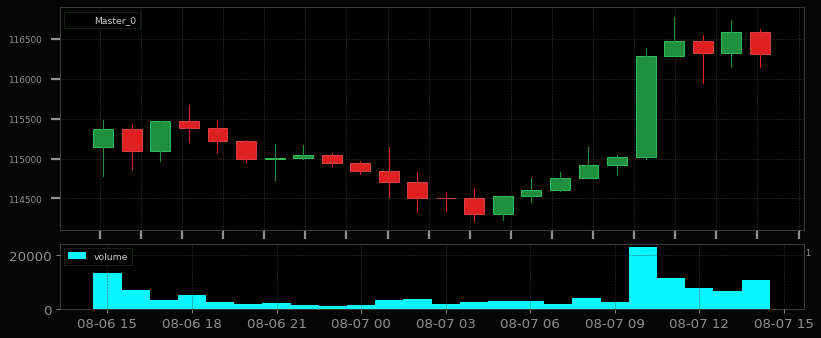

In [6]:
ohlc = ctx.ohlc(ctx.query_instrument("BTCUSDT")).pd()

LookingGlass(
    ohlc,
    {
        "volume": ["bars", ohlc["volume"]],
    },
    backend="mpl",
).look()

## 3.0 Plot the orderbook

In [7]:
symbol = "BTCUSDT"
instrument = ctx.query_instrument(symbol)
ob = ctx.get_data(instrument, DataType.ORDERBOOK[0.01, 100])[-1]
ob

[2025-08-07T14:48:59.712000000] 116318.0 (31.491999999999987) | 116318.1 (3.815999999999998)

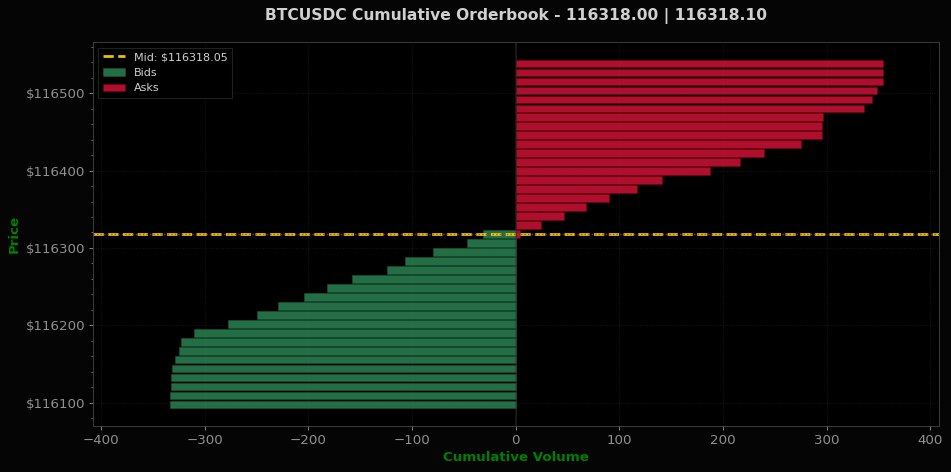

In [8]:
import matplotlib.pyplot as plt
from qubx.utils.charting.orderbook import plot_orderbook, plot_orderbook_depth, plot_orderbook_comparison

# Plot regular orderbook
# fig1, ax1 = plot_orderbook(ob, cumulative=False, max_levels=15, 
#                           title=f"BTCUSDC Orderbook - {ob.top_bid:.2f} | {ob.top_ask:.2f}")
# plt.show()

# Plot cumulative orderbook  
fig2, ax2 = plot_orderbook(ob, cumulative=True, max_levels=20,
                          title=f"BTCUSDC Cumulative Orderbook - {ob.top_bid:.2f} | {ob.top_ask:.2f}",
                          figsize=(12, 6))
plt.show()

# Plot depth chart
# fig3, ax3 = plot_orderbook_depth(ob, max_levels=15,
#                                 title=f"BTCUSDC Depth Chart - {ob.top_bid:.2f} | {ob.top_ask:.2f}")
# plt.show()

## 4.0 Orderbook Time Evolution Comparison

Let's compare how the orderbook has evolved over the last 10 snapshots.

In [9]:
obs = ctx.get_data(instrument, DataType.ORDERBOOK[0.01, 100])[-10:]
len(obs)

10

Comparing 5 orderbook snapshots
Actual timestamps: ['14:49:01.131', '14:49:01.338', '14:49:01.542', '14:49:01.750', '14:49:01.956']
Labels: ['Now', 'Now', 'Now', 'Now', 'Now']


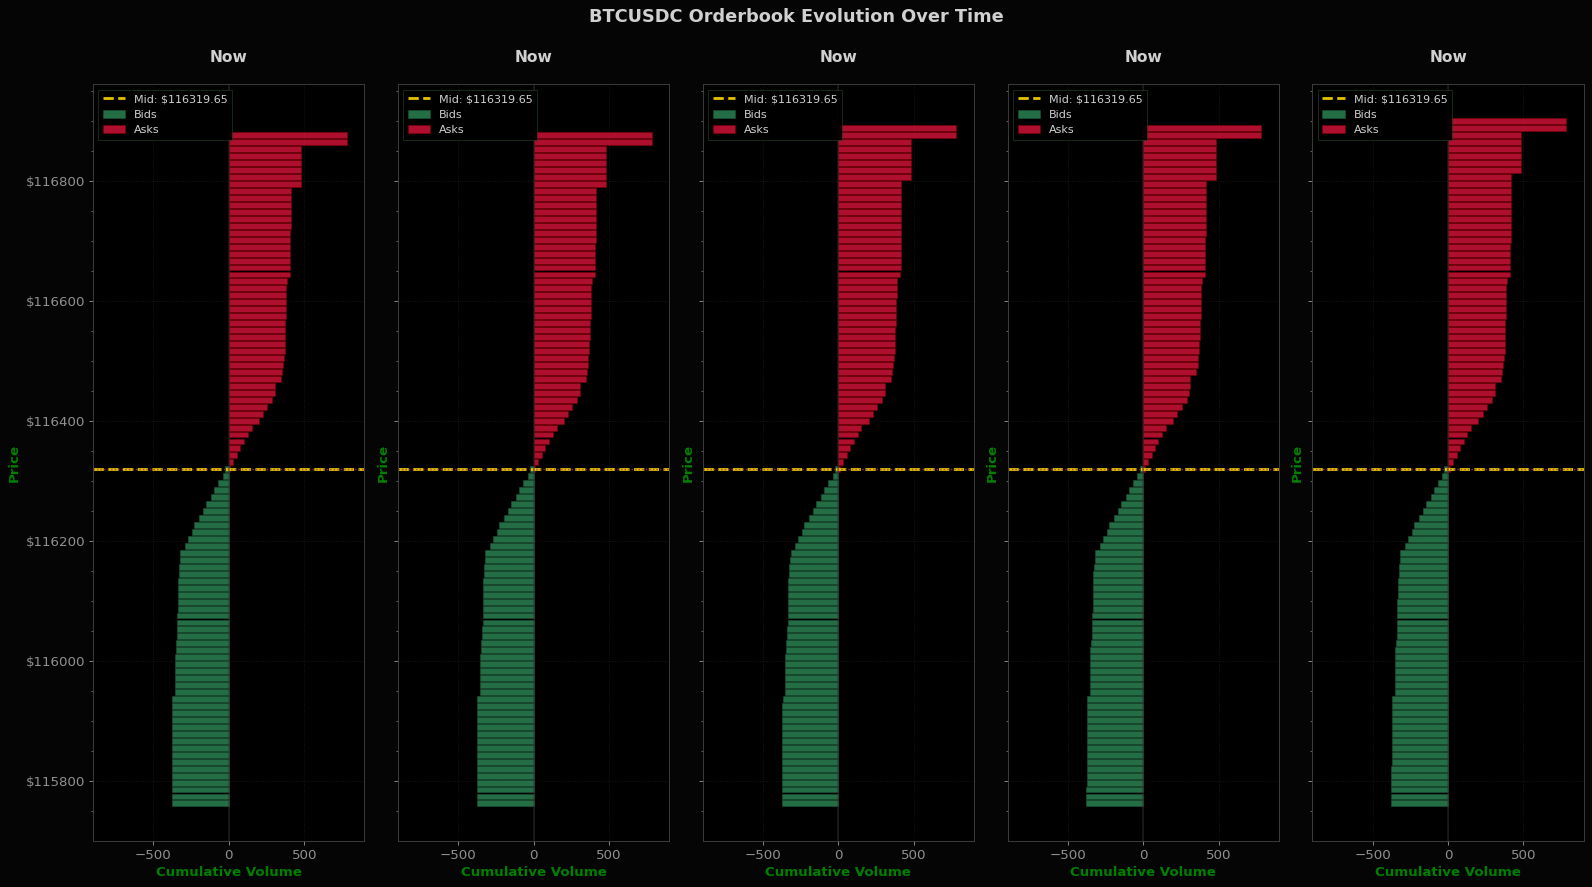

In [10]:
# Compare the evolution of orderbooks over time
# Let's take every 2nd orderbook to avoid overcrowding (5 total)
comparison_obs = obs[::2]  # Take every 2nd orderbook

# Create proper time labels using actual timestamps
timestamps = [pd.Timestamp(ob.time) for ob in comparison_obs]
current_time = pd.Timestamp(obs[-1].time)
labels = []

for ts in timestamps:
    seconds_ago = int((current_time - ts).total_seconds())
    if seconds_ago == 0:
        labels.append("Now")
    elif seconds_ago < 60:
        labels.append(f"T-{seconds_ago}s")
    else:
        minutes_ago = seconds_ago // 60
        labels.append(f"T-{minutes_ago}m{seconds_ago % 60}s")

print(f"Comparing {len(comparison_obs)} orderbook snapshots")
print("Actual timestamps:", [ts.strftime("%H:%M:%S.%f")[:-3] for ts in timestamps])
print("Labels:", labels)

# Create comparison plot
fig, axes = plot_orderbook_comparison(comparison_obs, labels=labels, 
                                    cumulative=True, figsize=(20, 12))
plt.suptitle('BTCUSDC Orderbook Evolution Over Time', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
ctx.stop()